<a href="https://colab.research.google.com/github/adityasuru95/SurgTools/blob/main/xml_parse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive') # Uncomment when running the notebook for first time
os.chdir("/content/drive/MyDrive/SurgTools")
os.getcwd()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/SurgTools'

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision
from torchvision import transforms as T
from torchvision import utils
import xml.etree.ElementTree as ET
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import default_collate
from tqdm import tqdm
import numpy as np

In [3]:
# Parse XML files
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    objects = []
    for obj in root.iter('object'):
        obj_dict = {
            'name': obj.find('name').text,
            'bbox': [
                int(obj.find('bndbox/xmin').text),
                int(obj.find('bndbox/ymin').text),
                int(obj.find('bndbox/xmax').text),
                int(obj.find('bndbox/ymax').text)
            ]
        }
        objects.append(obj_dict)
    return objects

In [ ]:
parse_xml("./m2cai16-tool-locations/Annotations/v01_002075.xml")

[{'name': 'Grasper', 'bbox': [201, 171, 256, 191]}]

In [4]:
# Visual bounding boxes
def visualize_image(image_path, objects):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR by default
    for obj in objects:
        bbox = obj['bbox']
        cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)
        cv2.putText(image, obj['name'], (bbox[0], bbox[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    plt.imshow(image)
    plt.show()


def visualize_image_2(image, objects):
  for obj in objects:
        obj['boxes'] = [int(i) for i in obj['boxes']]
        bbox = obj['boxes']
        cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)
        cv2.putText(image, obj['labels'], (bbox[0], bbox[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
  plt.imshow(image)
  plt.show()

# visualize_image("./m2cai16-tool-locations/JPEGImages/v01_002075.jpg", parse_xml("./m2cai16-tool-locations/Annotations/v01_002075.xml"))

In [5]:
your_label_map = {
    "Grasper": 1,
    "Bipolar": 2,
    "Hook": 3,
    "Scissors": 4,
    "Clipper": 5,
    "Irrigator": 6,
    "SpecimenBag": 7
}


def resize_bbox(bbox, in_size, out_size):
    """
    Adjust bounding box size.
    :param bbox: Original bounding box coordinates in the format [xmin, ymin, xmax, ymax]
    :param in_size: original image size (width, height)
    :param out_size: new image size (width, height)
    :return: adjusted bounding box coordinates
    """
    xmin, ymin, xmax, ymax = bbox
    scale_x = out_size[0] / in_size[0]
    scale_y = out_size[1] / in_size[1]
    xmin = int(xmin * scale_x)
    ymin = int(ymin * scale_y)
    xmax = int(xmax * scale_x)
    ymax = int(ymax * scale_y)
    return [xmin, ymin, xmax, ymax]


class CustomDataset(Dataset):
    def __init__(self, imgs_dir, anns_dir, transforms=None):
        self.imgs_dir = imgs_dir
        self.anns_dir = anns_dir
        self.transforms = transforms

        # Get the names of all image and annotation files, with extensions removed
        anns = set(os.path.splitext(file)[0] for file in os.listdir(anns_dir))
        imgs = anns

        # Keep image file names with matching annotations
        self.imgs = [file + '.jpg' for file in imgs]  # Assuming the image file is in .jpg format
        self.annotations = [file + '.xml' for file in anns]  # Assume that the annotation file is in .xml format

        # Make sure the image and annotation file lists are of equal length
        assert len(self.imgs) == len(self.annotations), "Images and annotations lists are not the same length"

    def __getitem__(self, idx):
        # print("getting")
        img_path = os.path.join(self.imgs_dir, self.imgs[idx])
        ann_path = os.path.join(self.anns_dir, self.annotations[idx])

        # read images
        image = Image.open(img_path).convert("RGB")
        original_size = image.size
        new_size = (600, 600)

        # Parse XML files using parse_xml function
        objects = parse_xml(ann_path)


        boxes = []
        labels = []
        num_objs = len(objects)
        for obj in objects:
            label_name = obj['name']
            label = your_label_map[label_name]  # Convert category name to integer
            labels.append(label)

            # Add bounding box coordinates
            bbox = obj['bbox']
            resized_bbox = resize_bbox(bbox, original_size, new_size)
            boxes.append(resized_bbox)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)


        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        # target["image_id"] = idx
        # target["area"] = area
        # target["iscrowd"] = iscrowd

        if self.transforms is not None:
            image = self.transforms(image)  # Apply conversion to image
            # If necessary, you can also convert the target accordingly
            # For example, if random flipping is used, the bounding box of the target needs to be adjusted accordingly

        return image, target

    def __len__(self):
        return len(self.imgs)


In [6]:
from torchvision.transforms import functional as F


# imgs_dir = "/content/m2cai16-tool-locations/JPEGImages"
# anns_dir = "/content/m2cai16-tool-locations/Annotations"

imgs_dir = "./m2cai16-tool-locations/JPEGImages/"
anns_dir = "./m2cai16-tool-locations/Annotations/"

def get_transform(train):
    transforms = []
    # Convert PIL image to PyTorch Tensor
    transforms.append(T.ToTensor())
    # if train:
    #     # Data augmentation during training phase, such as random horizontal flipping
    #     transforms.append(T.RandomHorizontalFlip(0.5))
    #     # More data enhancement operations can be added, such as:
    #     # transforms.append(T.RandomVerticalFlip(0.5))
    #     # transforms.append(T.ColorJitter(...))
    transforms.append(T.Resize((600, 600), antialias=None))  # 以 600x600 为例
    return T.Compose(transforms)


def collate_fn(batch):
    # Stack or pack images and targets separately, because images have different numbers of boxes
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]

    images = default_collate(images)  # Use default stacking method for images
    # Targets do not need to be stacked as they may be of different lengths
    return images, targets


# Create a dataset instance
dataset = CustomDataset(imgs_dir, anns_dir, transforms=get_transform(True))
# data_loader = DataLoader(dataset, batch_size=10, shuffle=True, num_workers=4, collate_fn=collate_fn)

generator2 = torch.Generator()#.manual_seed(42)
split_data = torch.utils.data.random_split(dataset, [0.7, 0.2, 0.1], generator=generator2)
train_dataset = split_data[0]
val_dataset = split_data[1]
test_dataset = split_data[2]

# len(train_dataset), len(val_dataset), len(test_dataset)

batchsize = 16
learnrate = 0.002

train_dataloader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True, num_workers=2, collate_fn=collate_fn)
val_datalaoder = DataLoader(val_dataset, batch_size=batchsize, shuffle=True, num_workers=2, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=2, collate_fn=collate_fn)


In [ ]:
images, labels = next(iter(train_dataloader))

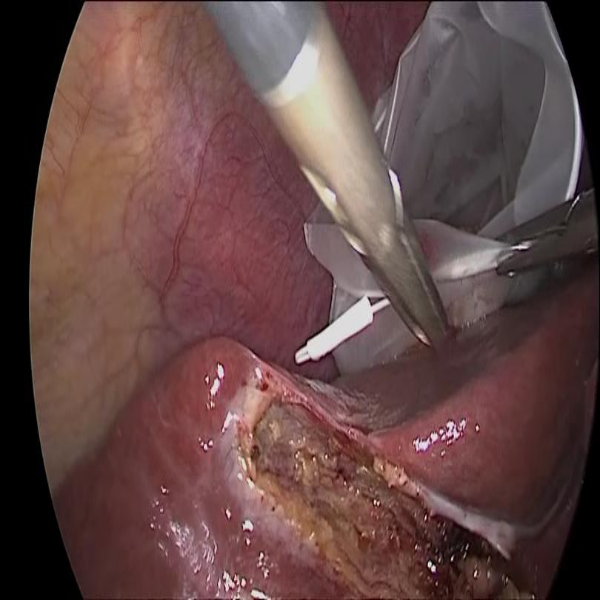

In [ ]:
F.to_pil_image(images[0])

In [7]:
def visualize_image_2(image_t, objects):
  image = np.transpose(image_t.numpy(), (1, 2, 0))
  image = (image * 255).astype(np.uint8).copy()
  bboxes = objects['boxes'].tolist()
  labels = objects['labels']
  labels = labels.tolist()
  for i in range(len(bboxes)):
        bbox = bboxes[i]
        bbox = [int(x) for x in bbox]
        cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)
        cv2.putText(image, str(labels[i]), (bbox[0], bbox[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
  plt.imshow(image)
  plt.show()

# i = 4
# visualize_image_2(images[i], labels[i])
# print(labels[i])

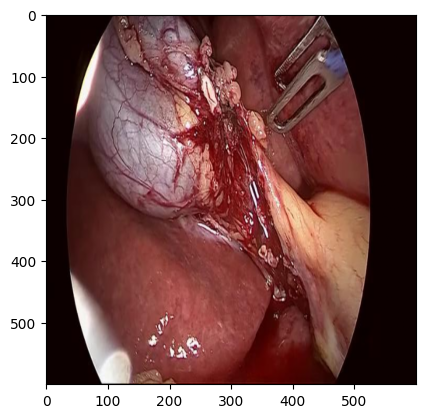

In [ ]:
# numpy_image = images[0].numpy()

# # Convert the numpy array to a cv2 image
# cv2_image = np.transpose(numpy_image, (1, 2, 0))
# # cv2_image = cv2.cvtColor(cv2_image, cv2.COLOR_BGR2RGB)

# # Display the image using cv2
# plt.imshow(cv2_image)
# plt.show()

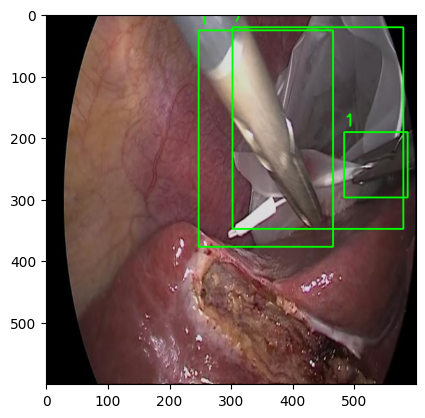

In [ ]:
visualize_image_2(images[0], labels[0])

In [ ]:
labels[0]

{'boxes': tensor([[302.,  21., 579., 348.],
         [483., 191., 586., 297.],
         [247.,  26., 465., 377.]]),
 'labels': tensor([7, 1, 1])}

In [8]:
def calculate_iou_for_labels(true_labels, pred_labels):
    # Initialize a list to store IoU values
    iou_values = []

    # Iterate over the pairs of true and predicted boxes
    for true_box, pred_box in zip(true_labels['boxes'], pred_labels['boxes']):
        # Extract box coordinates and convert to standard list format
        true_box = [b.item() for b in true_box]
        pred_box = [b.item() for b in pred_box]

        # Calculate the coordinates of the intersection rectangle
        xA = max(true_box[0], pred_box[0])
        yA = max(true_box[1], pred_box[1])
        xB = min(true_box[2], pred_box[2])
        yB = min(true_box[3], pred_box[3])

        # Compute the area of intersection rectangle
        interArea = max(0, xB - xA) * max(0, yB - yA)

        # Compute the area of both bounding boxes
        boxAArea = (true_box[2] - true_box[0]) * (true_box[3] - true_box[1])
        boxBArea = (pred_box[2] - pred_box[0]) * (pred_box[3] - pred_box[1])

        # Compute the intersection over union
        iou = interArea / float(boxAArea + boxBArea - interArea)

        # Append the IoU value to the list
        iou_values.append(iou)

    return iou_values

def calculate_iou_for_matching_classes_ordered(true_labels, pred_labels):
    iou_values = []

    # Iterate over each true box and its class
    for true_box, true_class in zip(true_labels['boxes'], true_labels['labels']):
        # Convert true box to standard list format
        true_box = [b.item() for b in true_box]

        best_iou = 0
        best_iou_class = None

        # Iterate over each predicted box and its class
        for pred_box, pred_class in zip(pred_labels['boxes'], pred_labels['labels']):
            # Check if the classes match
            if true_class == pred_class:
                # Convert predicted box to standard list format
                pred_box = [b.item() for b in pred_box]

                # Calculate IoU
                iou = calculate_single_iou(true_box, pred_box)

                # Update best IoU and class if current IoU is higher
                if iou > best_iou:
                    best_iou = iou
                    best_iou_class = pred_class

        if best_iou_class is not None:
            # Append the best IoU value and class to the list
            iou_values.append((best_iou, best_iou_class))

    return iou_values

def calculate_single_iou(boxA, boxB):
    # Calculate the coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # Compute the area of intersection rectangle
    interArea = max(0, xB - xA) * max(0, yB - yA)

    # Compute the area of both bounding boxes
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    # Compute the intersection over union
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

# def evaluate_model_on_validation_set(model, dataloader, device):
#     model.eval()
#     iou_scores = []

#     with torch.no_grad():
#         for images, targets in dataloader:
#             images = [image.to(device) for image in images]
#             targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
#             # Process only tensors in targets (like 'boxes' and 'labels'), ignore other data types
#             # targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]

#             # Get model predictions
#             preds = model(images)

#             # Convert predictions and targets to CPU and to numpy arrays for IoU calculation
#             for target, pred in zip(targets, preds):
#                 true_labels = {'boxes': target['boxes'].cpu(), 'labels': target['labels'].cpu()}
#                 pred_labels = {'boxes': pred['boxes'].cpu(), 'labels': pred['labels'].cpu()}
#                 iou_values = calculate_iou_for_matching_classes_ordered(true_labels, pred_labels)
#                 iou_scores.extend([iou for iou, _ in iou_values])

#     # Calculate average IoU
#     average_iou = np.mean(iou_scores) if iou_scores else 0
#     return average_iou

def evaluate_model_on_validation_set(model, dataloader, device, iou_threshold=0.5):
    model.eval()
    iou_scores = []
    total_true_objects = 0
    correctly_detected_objects = 0

    with torch.no_grad():
        for images, targets in dataloader:
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            preds = model(images)

            for target, pred in zip(targets, preds):
                true_labels = {'boxes': target['boxes'].cpu(), 'labels': target['labels'].cpu()}
                pred_labels = {'boxes': pred['boxes'].cpu(), 'labels': pred['labels'].cpu()}
                iou_values = calculate_iou_for_matching_classes_ordered(true_labels, pred_labels)

                total_true_objects += len(target['labels'])
                correctly_detected_objects += sum(iou >= iou_threshold for iou, _ in iou_values)

                iou_scores.extend([iou for iou, _ in iou_values])

    average_iou = np.mean(iou_scores) if iou_scores else 0
    accuracy = (correctly_detected_objects / total_true_objects) if total_true_objects else 0
    return average_iou, accuracy

In [9]:
import matplotlib.patches as patches
from torchvision.transforms import ToPILImage
def display_image_with_boxes_true(image, true_labels):
    fig, ax = plt.subplots(1)
    image = image.cpu()
    t = ToPILImage()
    image = t(image)

    # Image with true labels
    ax.imshow(image)
    n_obj_true = len(true_labels['boxes'])
    boxes = true_labels['boxes']
    labels = true_labels['labels']

    for i in range(n_obj_true):
      xmin, ymin, xmax, ymax = boxes[i][0].item(), boxes[i][1].item(), boxes[i][2].item(), boxes[i][3].item()
      rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin,
                               linewidth = 1, edgecolor='r', facecolor='none')
      ax.add_patch(rect)
      plt.text(xmin, ymin-5, labels[i], color='r')
    plt.show()


def display_image_with_boxes_pred(image, pred_labels):

    fig, ax = plt.subplots(1)
    image = image.cpu()
    t = ToPILImage()
    image = t(image)

    # Image with predicted labels
    ax.imshow(image)
    n_obj_true = len(pred_labels['boxes'])
    boxes = pred_labels['boxes']
    labels = pred_labels['labels']
    scores = pred_labels['scores']

    for i in range(n_obj_true):
      if(scores[i]>0.8):
        xmin, ymin, xmax, ymax = boxes[i][0].item(), boxes[i][1].item(), boxes[i][2].item(), boxes[i][3].item()
        rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin,
                                linewidth = 1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(xmin, ymin-5, labels[i], color='r')
        print(labels[i]) #del
    plt.show()

In [8]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load pre-trained model
model = fasterrcnn_resnet50_fpn(pretrained=True)

# Get the number of input features of the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

num_classes = 8
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
torch.cuda.is_available()

True

In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
reps = 1
num_epochs = 10
train_losses = np.zeros((reps, num_epochs))
val_IoU = np.zeros((reps, num_epochs))
accuracies = np.zeros((reps, num_epochs))
print("batch size=", batchsize, ", learning rate = ", learnrate, "\n\n")


for rep in range(reps):
  model = fasterrcnn_resnet50_fpn(pretrained=True)
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  num_classes = 8
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
  model.to(device)
  # choose optimizer
  optimizer = torch.optim.SGD(model.parameters(), lr=learnrate, momentum=0.9, weight_decay=0.00001)
  # optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005) #sgd original
  for epoch in range(num_epochs):
      print("rep, epoch = ", rep, epoch)
      model.train()
      for images, targets in tqdm(train_dataloader):
          images = list(image.to(device) for image in images)
          targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
          # targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]


          loss_dict = model(images, targets)
          losses = sum(loss for loss in loss_dict.values())

          optimizer.zero_grad()
          losses.backward()
          optimizer.step()

      train_loss = losses.item()


      model.eval()
      average_iou, accuracy = evaluate_model_on_validation_set(model, val_datalaoder, device)

      train_losses[rep][epoch] = train_loss
      val_IoU[rep][epoch] = average_iou
      accuracies[rep][epoch] = accuracy

      print(f"\nEpoch {epoch} Train Loss: {train_loss:.4f}")
      print(f"Epoch {epoch} Val IoU: {average_iou:.4f}")
      print(f"Epoch {epoch} Val Accuracy: {100*accuracy:.2f}\n")


batch size= 16 , learning rate =  0.002 


rep, epoch =  0 0


100%|██████████| 123/123 [05:51<00:00,  2.86s/it]



Epoch 0 Train Loss: 0.3325
Epoch 0 Val IoU: 0.6759
Epoch 0 Val Accuracy: 92.10

rep, epoch =  0 1


100%|██████████| 123/123 [05:36<00:00,  2.73s/it]



Epoch 1 Train Loss: 0.3329
Epoch 1 Val IoU: 0.7054
Epoch 1 Val Accuracy: 94.23

rep, epoch =  0 2


100%|██████████| 123/123 [05:35<00:00,  2.73s/it]



Epoch 2 Train Loss: 0.2376
Epoch 2 Val IoU: 0.7237
Epoch 2 Val Accuracy: 94.60

rep, epoch =  0 3


100%|██████████| 123/123 [05:34<00:00,  2.72s/it]



Epoch 3 Train Loss: 0.2133
Epoch 3 Val IoU: 0.7384
Epoch 3 Val Accuracy: 95.23

rep, epoch =  0 4


100%|██████████| 123/123 [05:32<00:00,  2.71s/it]



Epoch 4 Train Loss: 0.2026
Epoch 4 Val IoU: 0.7481
Epoch 4 Val Accuracy: 96.36

rep, epoch =  0 5


100%|██████████| 123/123 [05:32<00:00,  2.70s/it]



Epoch 5 Train Loss: 0.1741
Epoch 5 Val IoU: 0.7574
Epoch 5 Val Accuracy: 95.86

rep, epoch =  0 6


100%|██████████| 123/123 [05:31<00:00,  2.70s/it]



Epoch 6 Train Loss: 0.1376
Epoch 6 Val IoU: 0.7583
Epoch 6 Val Accuracy: 94.86

rep, epoch =  0 7


100%|██████████| 123/123 [05:31<00:00,  2.69s/it]



Epoch 7 Train Loss: 0.1681
Epoch 7 Val IoU: 0.7591
Epoch 7 Val Accuracy: 95.61

rep, epoch =  0 8


 55%|█████▌    | 68/123 [03:04<02:29,  2.71s/it]


KeyboardInterrupt: 

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [28]:
model_path = "./m2cai16-tool-locations/fastRCNN_train_8epochs.pth"
torch.save(model.state_dict(), model_path)

In [15]:
model_path = "./m2cai16-tool-locations/fastRCNN_train_8epochs.pth"
model.load_state_dict(torch.load(model_path))

<ipython-input-15-b3150377b2b8>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [29]:
torch.cuda.empty_cache()

In [10]:
images, targets = next(iter(train_dataloader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [16]:
# at the beginning
model.eval()
pred = model(images)

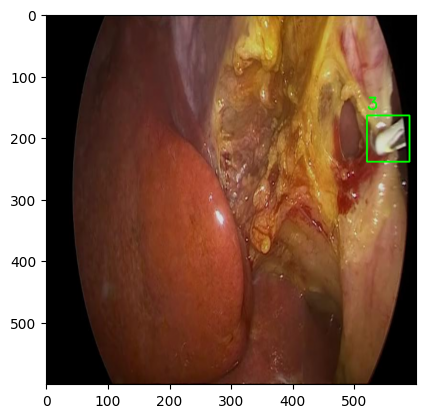

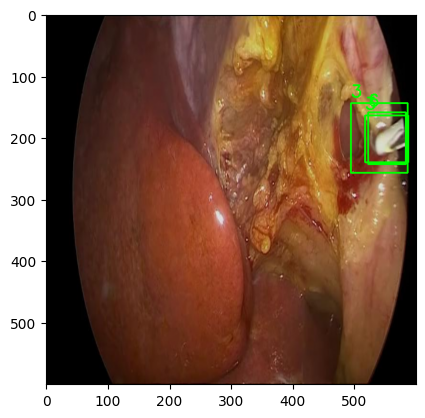

In [17]:
visualize_image_2(images[0].cpu(), targets[0])
visualize_image_2(images[0].cpu(), pred[0])

AttributeError: module 'torch.cuda' has no attribute 'clear_cache'

In [30]:
targets

[{'boxes': tensor([[319., 168., 509., 523.],
          [253., 426., 415., 586.]], device='cuda:0'),
  'labels': tensor([7, 1], device='cuda:0')},
 {'boxes': tensor([[364., 353., 510., 469.]], device='cuda:0'),
  'labels': tensor([2], device='cuda:0')},
 {'boxes': tensor([[253., 332., 359., 497.],
          [141.,  50., 276., 210.],
          [286.,  10., 388., 145.]], device='cuda:0'),
  'labels': tensor([4, 1, 1], device='cuda:0')},
 {'boxes': tensor([[415., 242., 511., 468.]], device='cuda:0'),
  'labels': tensor([5], device='cuda:0')},
 {'boxes': tensor([[127.,  51., 223., 310.],
          [349., 133., 500., 373.]], device='cuda:0'),
  'labels': tensor([2, 1], device='cuda:0')},
 {'boxes': tensor([[219., 238., 287., 387.]], device='cuda:0'),
  'labels': tensor([3], device='cuda:0')},
 {'boxes': tensor([[241., 141., 317., 255.]], device='cuda:0'),
  'labels': tensor([1], device='cuda:0')},
 {'boxes': tensor([[358., 263., 498., 435.],
          [121., 164., 197., 279.]], device='cuda:

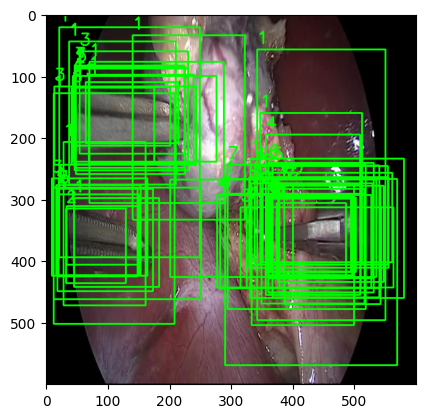

In [23]:
# at the beginning of the simulation
model.eval()
pred = model(images.to(device))
visualize_image_2(images[0], pred[0])